In [10]:
# Download dataset. This is not needed if you have the dataset already

# import kagglehub

# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path)

# Data Cleaning and Reformatting

In [1]:
# Function to check the sampling rate of a wav file and valid file path

import wave
import contextlib

def check_sampling_rate(file_path):
    try:
        with contextlib.closing(wave.open(file_path, 'r')) as wav_file:
            sample_rate = wav_file.getframerate()
            print(f"Sampling rate: {sample_rate} Hz")
    except Exception as e:
        print(f"Error: {e}")

file_path = 'data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-01-01-01.wav'
check_sampling_rate(file_path)

Sampling rate: 48000 Hz


In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import librosa
import matplotlib.pyplot as plt

In [4]:
"""
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).
"""


import os
import pandas as pd

emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

file_dir = "data/ravdess-emotional-speech-audio/versions/1/"

data = []

for actor in os.listdir(file_dir):
    actor_path = os.path.join(file_dir, actor)
    
    if os.path.isdir(actor_path) and actor.startswith("Actor_"):
        actor_number = actor.split("_")[-1]

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file[6:8]
                emotion = emotion_mapping.get(emotion_code, "unknown")
                formatted_filename = f"Actor_{actor_number}_{file}"
                data.append({"emotion": emotion, "file_path": formatted_filename})

df = pd.DataFrame(data)

print(df)

        emotion                          file_path
0       disgust  Actor_24_03-01-07-01-02-01-24.wav
1     surprised  Actor_24_03-01-08-02-01-01-24.wav
2           sad  Actor_24_03-01-04-01-02-01-24.wav
3         angry  Actor_24_03-01-05-01-01-01-24.wav
4           sad  Actor_24_03-01-04-02-01-01-24.wav
...         ...                                ...
1435    neutral  Actor_07_03-01-01-01-01-01-07.wav
1436      happy  Actor_07_03-01-03-02-01-02-07.wav
1437    neutral  Actor_07_03-01-01-01-01-02-07.wav
1438    disgust  Actor_07_03-01-07-02-01-02-07.wav
1439       calm  Actor_07_03-01-02-02-01-01-07.wav

[1440 rows x 2 columns]


In [5]:
#remove calm emotion
df = df[df.emotion != 'calm']

# Extracting waveforms and spectograms

In [6]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import torch
import matplotlib.pyplot as plt

torch.random.manual_seed(42)

def plot_waveform(waveform, sr, title=None, ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [7]:
def pull_wave_and_spec():
    base_dir = "data/ravdess-emotional-speech-audio/versions/1"
    output_dir = "speech"

    for actor in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor)
        if os.path.isdir(actor_path) and actor.startswith("Actor_"):
            actor_num = int(actor.split("_")[1])
            if actor_num > 22: # change actor number here because it keeps crashing midway
                print(f"Processing {actor}...")
                for file in os.listdir(actor_path):
                    if file.endswith(".wav"):
                        SAMPLE_SPEECH = os.path.join(actor_path, file)
                        SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

                        # Define transform
                        spectrogram = T.Spectrogram(n_fft=512)

                        # Perform transform
                        spec = spectrogram(SPEECH_WAVEFORM)
                        
                        fig, ax = plt.subplots()
                        plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title=None, ax=ax)
                        waveform_path = os.path.join(output_dir, f"{actor}_{file}_waveform.png")
                        plt.savefig(waveform_path)
                        plt.close(fig)

                        # Create figure for spectrogram
                        fig, ax = plt.subplots()
                        plot_spectrogram(spec[0], title=None, ax=ax)
                        spectrogram_path = os.path.join(output_dir, f"{actor}_{file}_spectrogram.png")
                        plt.savefig(spectrogram_path)
                        plt.close(fig)

# Connecting speech waveforms and spectogram to pd dataframe

In [9]:
import torchvision.transforms as transforms
from PIL import Image

# Define base path for spectrogram images
image_dir = "speech"  # Directory where spectrogram images are stored

# Define transformations (convert images to tensors)
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization (optional)
])

# Function to load spectrogram as tensor
def load_spectrogram_tensor(file_path):
    filename = os.path.basename(file_path)
    spectrogram_img_path = os.path.join(image_dir, f"{filename}_spectrogram.png")  # Construct spectrogram path
    
    # Load image if it exists, else return None
    if os.path.exists(spectrogram_img_path):
        image = Image.open(spectrogram_img_path).convert("L")  # Convert to grayscale
        return transform(image)  # Convert to tensor
    return None  # If file doesn't exist, return None

# Apply function to extract spectrogram tensors
df["spectrogram_tensor"] = df["file_path"].apply(load_spectrogram_tensor)

# Display updated DataFrame
print(df.head())


     emotion                          file_path  \
0    disgust  Actor_24_03-01-07-01-02-01-24.wav   
1  surprised  Actor_24_03-01-08-02-01-01-24.wav   
2        sad  Actor_24_03-01-04-01-02-01-24.wav   
3      angry  Actor_24_03-01-05-01-01-01-24.wav   
4        sad  Actor_24_03-01-04-02-01-01-24.wav   

                                  spectrogram_tensor  
0  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
1  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
2  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
3  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
4  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  


In [10]:
import torchvision.transforms as transforms
from PIL import Image
import os
import pandas as pd

# Define base path for waveform images
image_dir = "speech"  # Directory where waveform images are stored

# Define transformations (convert images to tensors)
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization (optional)
])

# Function to load waveform as tensor
def load_waveform_tensor(file_path):
    filename = os.path.basename(file_path)  # Extract filename (e.g., "Actor_01_03-01-01-01-01-01-01.wav")
    waveform_img_path = os.path.join(image_dir, f"{filename}_waveform.png")  # Construct waveform path
    
    # Load image if it exists, else return None
    if os.path.exists(waveform_img_path):
        image = Image.open(waveform_img_path).convert("L")  # Convert to grayscale
        return transform(image)  # Convert to tensor
    return None  # If file doesn't exist, return None

# Apply function to extract waveform tensors
df["waveform_tensor"] = df["file_path"].apply(load_waveform_tensor)

# Display updated DataFrame
print(df.head())

     emotion                          file_path  \
0    disgust  Actor_24_03-01-07-01-02-01-24.wav   
1  surprised  Actor_24_03-01-08-02-01-01-24.wav   
2        sad  Actor_24_03-01-04-01-02-01-24.wav   
3      angry  Actor_24_03-01-05-01-01-01-24.wav   
4        sad  Actor_24_03-01-04-02-01-01-24.wav   

                                  spectrogram_tensor  \
0  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
1  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
2  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
3  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
4  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   

                                     waveform_tensor  
0  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
1  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
2  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
3  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
4  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  


# Creating the model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [77]:
df['emotion'].value_counts()

emotion
disgust      192
surprised    192
sad          192
angry        192
fearful      192
happy        192
neutral       96
Name: count, dtype: int64

In [11]:
print(df.iloc[0, 2].shape)
print(df.iloc[0, 3].shape)

#combined = torch.cat([tensor1, tensor2], dim=0)

torch.Size([1, 480, 640])
torch.Size([1, 480, 640])


In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)
torch.manual_seed(42);

In [14]:
train_df.iloc[0]['spectrogram_tensor']

emotion_to_num = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

train_set = []
test_set = []

#create train set 
for i in range(len(train_df)):
  #concat the spectogram and waveform tensors into one 
  combined = torch.cat([train_df.iloc[i]['spectrogram_tensor'], train_df.iloc[i]['waveform_tensor']], dim=0)
  label_tensor = torch.tensor(emotion_to_num[train_df.iloc[i]['emotion']], dtype=torch.long)
  #save to dataset 
  train_set.append((combined, label_tensor))

#create test set 
for i in range(len(test_df)):
  #concat the spectogram and waveform tensors into one 
  combined = torch.cat([test_df.iloc[i]['spectrogram_tensor'], test_df.iloc[i]['waveform_tensor']], dim=0)
  label_tensor = torch.tensor(emotion_to_num[test_df.iloc[i]['emotion']], dtype=torch.long)
  test_set.append((combined, label_tensor))
  

In [98]:
BATCH_SIZE = 16  # <-- Please change this as necessary
NUM_WORKERS = 4  # <-- Use more workers for more CPU threads

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 120 * 160, 128)  # Fixed input size
        self.fc2 = nn.Linear(128, 7)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv + ReLU + Pooling
        x = torch.flatten(x, start_dim=1)  # Flatten for the FC layer
        x = F.relu(self.fc1(x))  # Hidden layer
        x = self.dropout(x)  # Apply dropout after the fully connected layer
        x = self.fc2(x)  # Output logits (no softmax needed before CrossEntropyLoss)
        return x


In [103]:
from tqdm import tqdm 
import numpy as np

def train(train_loader, model, optimizer, criterion, n_epochs=10, **kwargs):
    ### Define your training loop here
    model.train()
    losses = []
    for i in tqdm(range(n_epochs)):
          print(i)
          batch_losses = []
          correct = 0  
          total = 0
          lastepoch_loss = 0
        
          for j, data in enumerate(train_loader, 0):  
            
            x_batch, y_batch = data
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  
            
            optimizer.zero_grad()
            
            y_predictions = model(x_batch)
            loss = criterion(y_predictions, y_batch)
            loss.backward() 
            optimizer.step()
            
            batch_losses.append(loss.item())
              
            _, predicted = torch.max(y_predictions, 1)  # Get class with highest score
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

          epoch_loss = np.mean(batch_losses)
          losses.append(epoch_loss)
          epoch_accuracy = 100 * correct / total

          print(f"Train Loss: {losses[-1]:.4f} | Train Accuracy: {epoch_accuracy:.2f}%\n")

          #break out of for loop if the loss is not improving significantly 
          if abs(lastepoch_loss-epoch_loss) < 0.01: 
              print("stopping early")
              break
          lastepoch_loss = epoch_loss 
        
    return losses 

In [104]:
from torch import optim

mymodel = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-3, weight_decay=1e-5)

In [105]:
epochs = 50

losses = train(train_loader, mymodel, optimizer, criterion, epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

0


  2%|▏         | 1/50 [00:06<05:28,  6.71s/it]

Train Loss: 3.2655 | Train Accuracy: 13.93%

1


  4%|▍         | 2/50 [00:13<05:25,  6.78s/it]

Train Loss: 1.9369 | Train Accuracy: 15.33%

2


  6%|▌         | 3/50 [00:20<05:15,  6.72s/it]

Train Loss: 1.9204 | Train Accuracy: 18.74%

3


  8%|▊         | 4/50 [00:26<05:10,  6.75s/it]

Train Loss: 1.8610 | Train Accuracy: 24.45%

4


 10%|█         | 5/50 [00:33<05:04,  6.76s/it]

Train Loss: 1.7601 | Train Accuracy: 31.86%

5


 12%|█▏        | 6/50 [00:40<04:57,  6.77s/it]

Train Loss: 1.6155 | Train Accuracy: 35.77%

6


 14%|█▍        | 7/50 [00:47<04:49,  6.74s/it]

Train Loss: 1.4664 | Train Accuracy: 42.99%

7


 16%|█▌        | 8/50 [00:53<04:43,  6.75s/it]

Train Loss: 1.4064 | Train Accuracy: 45.29%

8


 18%|█▊        | 9/50 [01:00<04:35,  6.73s/it]

Train Loss: 1.3184 | Train Accuracy: 47.09%

9


 20%|██        | 10/50 [01:07<04:29,  6.73s/it]

Train Loss: 1.1531 | Train Accuracy: 57.72%

10


 22%|██▏       | 11/50 [01:14<04:23,  6.76s/it]

Train Loss: 1.0525 | Train Accuracy: 59.52%

11


 24%|██▍       | 12/50 [01:21<04:17,  6.77s/it]

Train Loss: 0.9368 | Train Accuracy: 62.83%

12


 26%|██▌       | 13/50 [01:27<04:09,  6.74s/it]

Train Loss: 0.8815 | Train Accuracy: 66.63%

13


 28%|██▊       | 14/50 [01:34<04:03,  6.76s/it]

Train Loss: 0.7956 | Train Accuracy: 70.24%

14


 30%|███       | 15/50 [01:41<03:57,  6.79s/it]

Train Loss: 0.6836 | Train Accuracy: 72.34%

15


 32%|███▏      | 16/50 [01:48<03:50,  6.79s/it]

Train Loss: 0.6063 | Train Accuracy: 76.55%

16


 34%|███▍      | 17/50 [01:54<03:43,  6.78s/it]

Train Loss: 0.5463 | Train Accuracy: 78.56%

17


 36%|███▌      | 18/50 [02:01<03:37,  6.78s/it]

Train Loss: 0.5414 | Train Accuracy: 79.46%

18


 38%|███▊      | 19/50 [02:08<03:29,  6.75s/it]

Train Loss: 0.4682 | Train Accuracy: 80.36%

19


 40%|████      | 20/50 [02:15<03:22,  6.76s/it]

Train Loss: 0.4582 | Train Accuracy: 80.56%

20


 42%|████▏     | 21/50 [02:21<03:16,  6.77s/it]

Train Loss: 0.4334 | Train Accuracy: 81.66%

21


 44%|████▍     | 22/50 [02:28<03:09,  6.78s/it]

Train Loss: 0.4218 | Train Accuracy: 83.17%

22


 46%|████▌     | 23/50 [02:35<03:03,  6.78s/it]

Train Loss: 0.4300 | Train Accuracy: 82.67%

23


 48%|████▊     | 24/50 [02:42<02:56,  6.81s/it]

Train Loss: 0.3726 | Train Accuracy: 84.77%

24


 50%|█████     | 25/50 [02:49<02:49,  6.77s/it]

Train Loss: 0.3902 | Train Accuracy: 83.37%

25


 52%|█████▏    | 26/50 [02:55<02:42,  6.77s/it]

Train Loss: 0.3273 | Train Accuracy: 85.97%

26


 54%|█████▍    | 27/50 [03:02<02:35,  6.76s/it]

Train Loss: 0.3324 | Train Accuracy: 86.87%

27


 56%|█████▌    | 28/50 [03:09<02:28,  6.77s/it]

Train Loss: 0.3292 | Train Accuracy: 86.27%

28


 58%|█████▊    | 29/50 [03:16<02:21,  6.76s/it]

Train Loss: 0.3054 | Train Accuracy: 87.37%

29


 60%|██████    | 30/50 [03:22<02:15,  6.76s/it]

Train Loss: 0.2607 | Train Accuracy: 88.58%

30


 62%|██████▏   | 31/50 [03:29<02:08,  6.78s/it]

Train Loss: 0.2940 | Train Accuracy: 87.98%

31


 64%|██████▍   | 32/50 [03:36<02:01,  6.75s/it]

Train Loss: 0.2660 | Train Accuracy: 88.28%

32


 66%|██████▌   | 33/50 [03:43<01:54,  6.76s/it]

Train Loss: 0.2802 | Train Accuracy: 87.98%

33


 68%|██████▊   | 34/50 [03:49<01:47,  6.73s/it]

Train Loss: 0.2718 | Train Accuracy: 88.58%

34


 70%|███████   | 35/50 [03:56<01:40,  6.73s/it]

Train Loss: 0.2809 | Train Accuracy: 87.88%

35


 72%|███████▏  | 36/50 [04:03<01:34,  6.73s/it]

Train Loss: 0.2860 | Train Accuracy: 88.28%

36


 74%|███████▍  | 37/50 [04:10<01:28,  6.77s/it]

Train Loss: 0.2749 | Train Accuracy: 88.28%

37


 76%|███████▌  | 38/50 [04:16<01:21,  6.77s/it]

Train Loss: 0.2152 | Train Accuracy: 92.08%

38


 78%|███████▊  | 39/50 [04:23<01:14,  6.77s/it]

Train Loss: 0.2506 | Train Accuracy: 89.68%

39


 80%|████████  | 40/50 [04:30<01:07,  6.76s/it]

Train Loss: 0.2611 | Train Accuracy: 88.38%

40


 82%|████████▏ | 41/50 [04:37<01:00,  6.76s/it]

Train Loss: 0.2484 | Train Accuracy: 89.48%

41


 84%|████████▍ | 42/50 [04:43<00:53,  6.74s/it]

Train Loss: 0.2571 | Train Accuracy: 89.08%

42


 86%|████████▌ | 43/50 [04:50<00:47,  6.74s/it]

Train Loss: 0.2248 | Train Accuracy: 90.78%

43


 88%|████████▊ | 44/50 [04:57<00:40,  6.77s/it]

Train Loss: 0.2481 | Train Accuracy: 89.18%

44


 90%|█████████ | 45/50 [05:04<00:33,  6.74s/it]

Train Loss: 0.2331 | Train Accuracy: 90.28%

45


 92%|█████████▏| 46/50 [05:10<00:26,  6.73s/it]

Train Loss: 0.2339 | Train Accuracy: 89.68%

46


 94%|█████████▍| 47/50 [05:17<00:20,  6.78s/it]

Train Loss: 0.2044 | Train Accuracy: 91.68%

47


 96%|█████████▌| 48/50 [05:24<00:13,  6.81s/it]

Train Loss: 0.2130 | Train Accuracy: 91.48%

48


 98%|█████████▊| 49/50 [05:31<00:06,  6.79s/it]

Train Loss: 0.2012 | Train Accuracy: 91.08%

49


100%|██████████| 50/50 [05:38<00:00,  6.76s/it]

Train Loss: 0.2275 | Train Accuracy: 89.98%



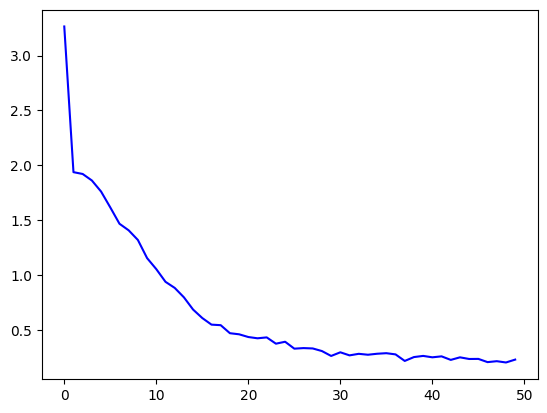

In [106]:
from matplotlib import pyplot as plt 


plt.plot(np.arange(len(losses)), losses, label='Loss Plot', color='blue')

In [107]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():  # We don't need gradients for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)  # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Accuracy as a percentage
    return accuracy


In [108]:
accuracy = calculate_accuracy(mymodel, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 31.20%
